<a href="https://colab.research.google.com/github/DLShrankhala/DevelopingVariousLSTMModelForTimeSeriesForecasting-ai-25/blob/main/Siddhant_AdaniPorts_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siddhant_AdaniPorts_LSTM

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [ ]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        """Reads a CSV file into the dataframe."""
        if os.path.exists(file_name):
            self.dataframe = pd.read_csv(file_name)
            print(f"Data successfully read from {file_name}.")
        else:
            print(f"Error: The file {file_name} does not exist.")

    def clean_data(self):
        """Removes null values from the dataframe."""
        initial_shape = self.dataframe.shape
        self.dataframe.dropna(inplace=True)
        final_shape = self.dataframe.shape
        print(f"Data cleaned: {initial_shape[0] - final_shape[0]} rows removed.")

    def print_head(self):
        """Prints first few rows of the dataframe."""
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print(self.dataframe.describe())

    def normalize(self):
        """Normalizes numeric columns in the dataframe."""
        numeric_cols = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.scaler = MinMaxScaler()
        self.dataframe[numeric_cols] = self.scaler.fit_transform(self.dataframe[numeric_cols])
        print(f"Data normalized for columns: {numeric_cols.tolist()}")

    def visualize_open(self):
        """Plot graph for open stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Open column not found in the dataframe")

    def visualize_close(self):
        """Plot graph for close stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Close column not found in the dataframe")



In [ ]:
data = Data()

In [ ]:
data.read('/content/ADANIPORTS.csv')

Data successfully read from /content/ADANIPORTS.csv.


In [ ]:
data.clean_data()

Data cleaned: 0 rows removed.


In [ ]:
data.print_head()

         Date        Open        High         Low       Close   Adj Close  \
0  2009-05-29  118.199997  129.800003  118.199997  122.239998  112.648827   
1  2009-06-01  124.900002  131.800003  124.019997  130.229996  120.011932   
2  2009-06-02  132.399994  132.759995  122.510002  125.800003  115.929504   
3  2009-06-03  127.000000  129.639999  116.199997  120.190002  110.759682   
4  2009-06-04  119.400002  124.800003  118.099998  124.050003  114.316818   

    Volume  
0  4723135  
1  4107615  
2  2127755  
3  3195210  
4  1730245  


In [ ]:
data.print_description()

              Open         High          Low        Close    Adj Close  \
count  3700.000000  3700.000000  3700.000000  3700.000000  3700.000000   
mean    377.372381   383.175009   370.768200   376.790659   367.092732   
std     271.243405   274.742450   267.077888   270.697135   272.088564   
min      98.180000    98.980003    93.430000    96.279999    88.886612   
25%     151.575005   154.899994   149.087505   151.300003   142.119858   
50%     317.000000   321.199997   311.524994   316.049988   304.311554   
75%     413.624992   417.737511   408.025002   413.350006   399.630219   
max    1445.000000  1457.050049  1423.599976  1443.349976  1443.349976   

             Volume  
count  3.700000e+03  
mean   4.331447e+06  
std    6.189654e+06  
min    0.000000e+00  
25%    1.634871e+06  
50%    2.837244e+06  
75%    4.815716e+06  
max    1.155175e+08  


In [ ]:
data.normalize()

Data normalized for columns: ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


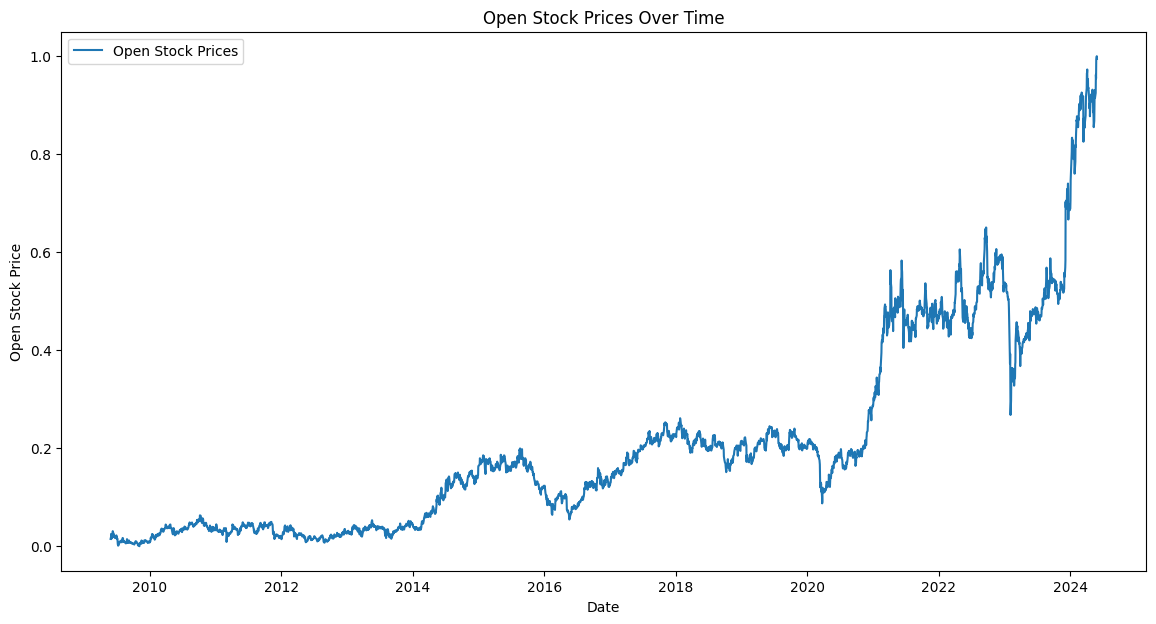

In [ ]:
data.visualize_open()

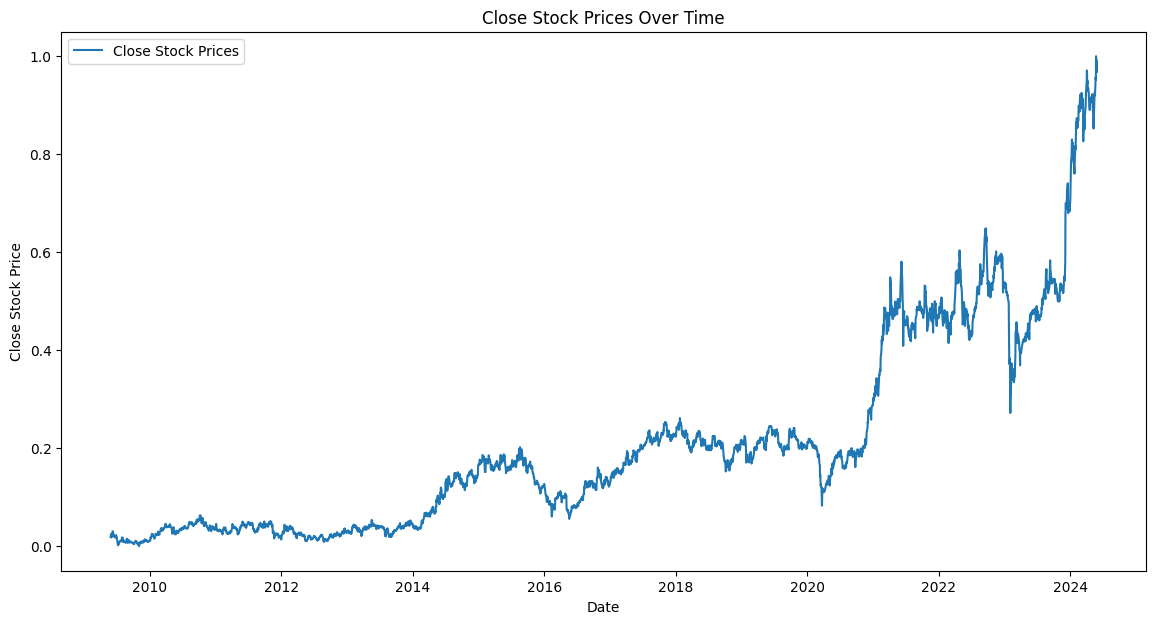

In [ ]:
data.visualize_close()

In [ ]:
class LSTMTrainer:
    def __init__(self, dataframe, scaler):
        self.dataframe = dataframe
        self.scaler = scaler

    def prepare_data_for_lstm(self, feature_col='Close', look_back=60):
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)  # Reshape to (n_samples, 1)
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])
        X, y = np.array(X), np.array(y)

        # Split data while preserving the number of features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        return X_train, X_test, y_train, y_test.reshape(-1, 1)

    def build_and_train_lstm(self, feature_col='Close', look_back=60, epochs=40, batch_size=32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)
        predictions = predictions.reshape(-1, 1)

        # Extract the 'Close' column from the original dataframe
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))  # Create a new scaler for just the 'Close' column
        self.close_scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))  # Fit the scaler to the 'Close' column

        # Inverse transform predictions using the scaler fitted on 'Close' column
        predictions = self.close_scaler.inverse_transform(predictions)
        # Inverse transform actual 'Close' values
        actual = self.close_scaler.inverse_transform(self.y_test)

        plt.figure(figsize=(14, 7))
        plt.plot(actual, label='Actual Stock Price')
        plt.plot(predictions, label='Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        """Calculates and prints evaluation metrics."""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)  # Assuming you're using the close_scaler
        actual = self.close_scaler.inverse_transform(self.y_test)

        mse = mean_squared_error(actual, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actual, predictions)
        r2 = r2_score(actual, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R2): {r2}")



In [ ]:
trainer = LSTMTrainer(data.dataframe, data.scaler)

In [ ]:
trainer.build_and_train_lstm(feature_col='Close', look_back=60, epochs=40, batch_size=32)

Epoch 1/40
91/91 [==============================] - 10s 67ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2/40
91/91 [==============================] - 5s 54ms/step - loss: 1.3414e-04 - val_loss: 0.0015
Epoch 3/40
91/91 [==============================] - 5s 50ms/step - loss: 1.2527e-04 - val_loss: 0.0011
Epoch 4/40
91/91 [==============================] - 6s 63ms/step - loss: 1.1704e-04 - val_loss: 0.0010
Epoch 5/40
91/91 [==============================] - 4s 47ms/step - loss: 1.1447e-04 - val_loss: 9.5970e-04
Epoch 6/40
91/91 [==============================] - 4s 49ms/step - loss: 1.0554e-04 - val_loss: 9.4323e-04
Epoch 7/40
91/91 [==============================] - 7s 77ms/step - loss: 1.0874e-04 - val_loss: 0.0010
Epoch 8/40
91/91 [==============================] - 5s 49ms/step - loss: 1.0746e-04 - val_loss: 0.0011
Epoch 9/40
91/91 [==============================] - 4s 49ms/step - loss: 1.0439e-04 - val_loss: 9.3362e-04
Epoch 10/40
91/91 [==============================] - 6s 67ms/ste

23/23 [==============================] - 2s 23ms/step


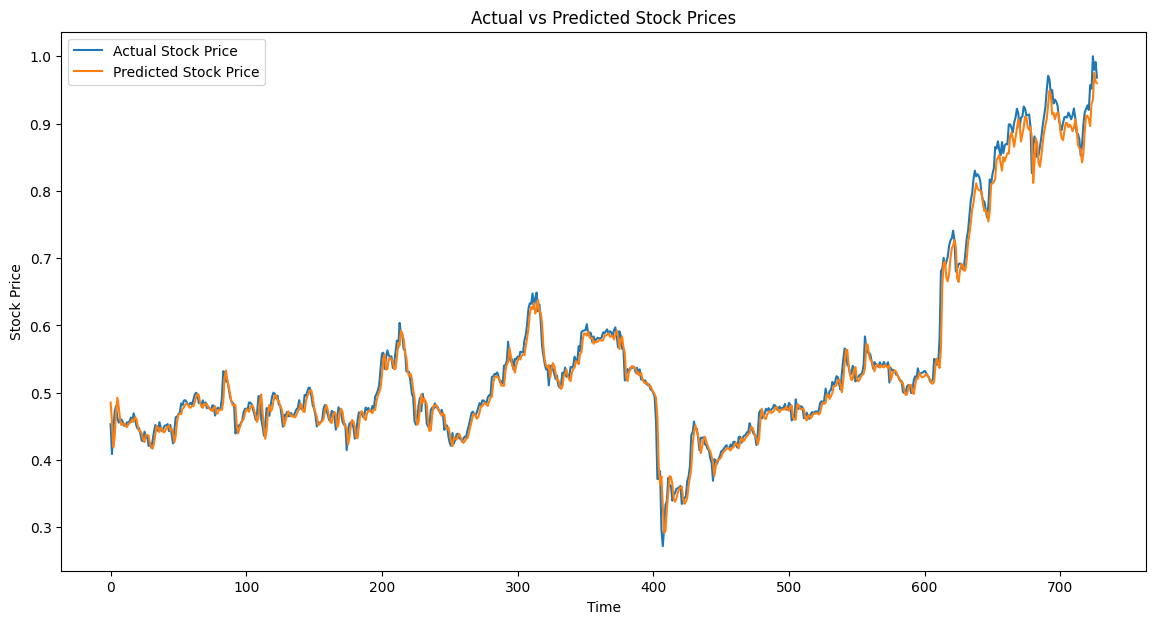

In [ ]:
trainer.predict_and_plot()

In [ ]:
trainer.evaluate_model()

23/23 [==============================] - 1s 24ms/step
Mean Squared Error (MSE): 0.00028464205616314026
Root Mean Squared Error (RMSE): 0.016871338303855454
Mean Absolute Error (MAE): 0.011656939307454919
R-squared (R2): 0.9867405584007481


In [ ]:
with open('model.pkl','wb') as f:
  pickle.dump(trainer,f)

In [ ]:
with open('model.pkl','rb') as f:
  trained_model = pickle.load(f)

23/23 [==============================] - 2s 24ms/step


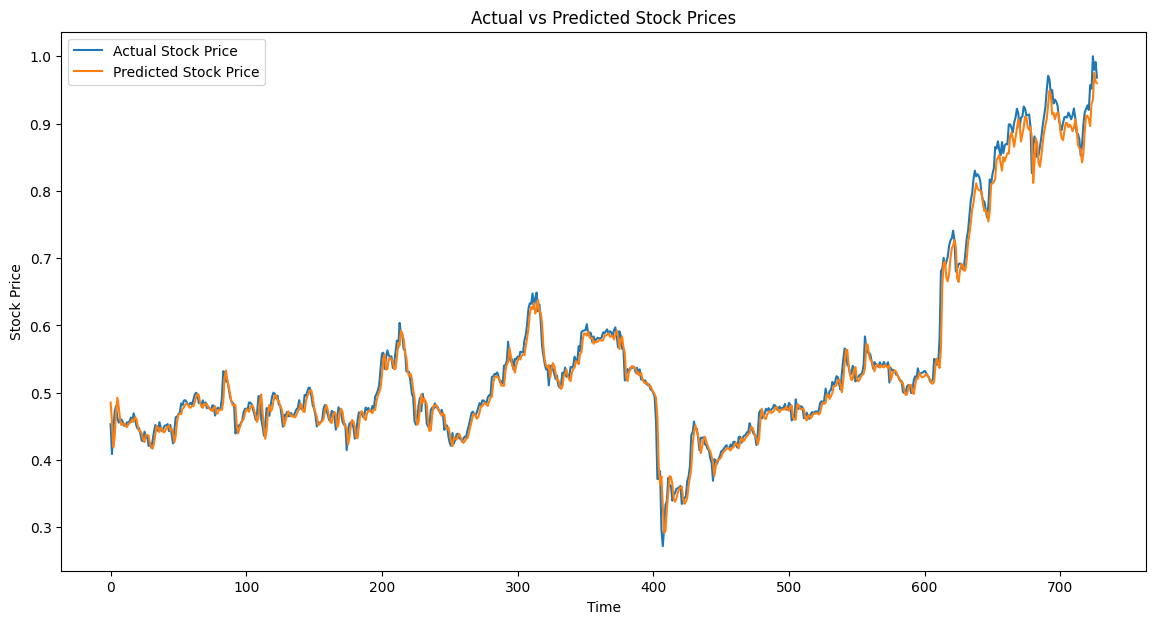

In [ ]:
# Predicting and ploting using loaded model
trained_model.predict_and_plot()

In [ ]:
trained_model.evaluate_model()

23/23 [==============================] - 1s 38ms/step
Mean Squared Error (MSE): 0.00028464205616314026
Root Mean Squared Error (RMSE): 0.016871338303855454
Mean Absolute Error (MAE): 0.011656939307454919
R-squared (R2): 0.9867405584007481
